## Credit Card Defaulters Prediction ##

In [1]:
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
import xgboost
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from matplotlib import pyplot as plt
from numpy import mean, std 
import numpy as np
from xgboost import XGBRFClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
## Read input data ##
data = pd.read_excel('data.xls')
print(data.head(5))
# print(data.shape)

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  ...  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month
0   1      20000    2          2         1  ...         0         0         0         0                           1
1   2     120000    2          2         2  ...      1000      1000         0      2000                           1
2   3      90000    2          2         2  ...      1000      1000      1000      5000                           0
3   4      50000    2          2         1  ...      1200      1100      1069      1000                           0
4   5      50000    1          2         1  ...     10000      9000       689       679                           0

[5 rows x 25 columns]


In [3]:
## List of variables available ##
print(list(data.columns))

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


# Data Quality Analysis

In [4]:
## NA values across the data ##
data.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [5]:
## Check for duplicated records ##
data[data.duplicated()] 

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month


# Exploratory Data Analysis

In [6]:
## To drop ID column & understand the data distribution of all variables ##
data = data.drop('ID', axis=1)
print(data.shape)
print(data.describe())

(30000, 24)
            LIMIT_BAL           SEX     EDUCATION  ...       PAY_AMT5       PAY_AMT6  default payment next month
count    30000.000000  30000.000000  30000.000000  ...   30000.000000   30000.000000                30000.000000
mean    167484.322667      1.603733      1.853133  ...    4799.387633    5215.502567                    0.221200
std     129747.661567      0.489129      0.790349  ...   15278.305679   17777.465775                    0.415062
min      10000.000000      1.000000      0.000000  ...       0.000000       0.000000                    0.000000
25%      50000.000000      1.000000      1.000000  ...     252.500000     117.750000                    0.000000
50%     140000.000000      2.000000      2.000000  ...    1500.000000    1500.000000                    0.000000
75%     240000.000000      2.000000      2.000000  ...    4031.500000    4000.000000                    0.000000
max    1000000.000000      2.000000      6.000000  ...  426529.000000  528666.000000

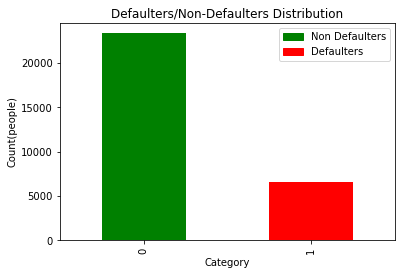

In [7]:
## Distribution of target variable ##
import matplotlib.patches as mpatches
counts_ = data['default payment next month'].value_counts()
colors = ['green', 'red']
plot_ = counts_.plot(kind='bar', title='Defaulters/Non-Defaulters Distribution', color=colors)
plot_.set_xlabel("Category")
plot_.set_ylabel("Count(people)")
a = mpatches.Patch(color='green', label='Non Defaulters')
b = mpatches.Patch(color='red', label='Defaulters')

plot_.legend(handles=[a,b], loc='best')

plt.show()

In [8]:
### Seggregate defaulters & non defaulters ###
defaulters_data = data.loc[data['default payment next month'] == 1]
non_defaulters_data = data.loc[data['default payment next month'] == 0]

print("Defaulters:", round(len(defaulters_data)/len(data)*100.0, 1), "%")
print("Non-defaulters:", round(len(non_defaulters_data)/len(data)*100.0,1), "%")

Defaulters: 22.1 %
Non-defaulters: 77.9 %


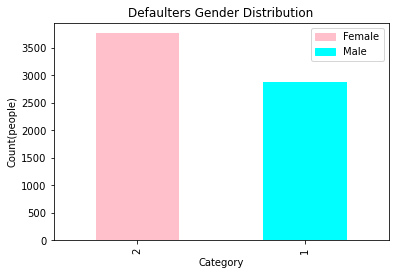

In [9]:
## Viz about gender feature ##
counts_ = defaulters_data['SEX'].value_counts()
colors = ['pink', 'cyan']
plot_ = counts_.plot(kind='bar', title='Defaulters Gender Distribution', color=colors)
plot_.set_xlabel("Category")
plot_.set_ylabel("Count(people)")
a = mpatches.Patch(color='pink', label='Female')
b = mpatches.Patch(color='cyan', label='Male')

plot_.legend(handles=[a,b], loc='best')
plt.show()

50000     885
20000     698
30000     568
80000     363
100000    272
200000    270
60000     233
70000     210
10000     197
150000    187
Name: LIMIT_BAL, dtype: int64


<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

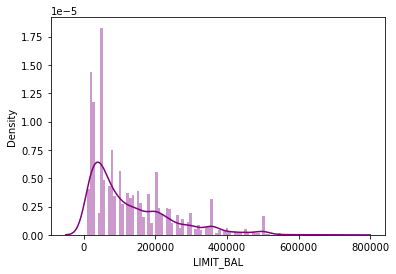

In [10]:
## To find out the spread of limit balances among the defaulters ##
limit_bal_defaulters = defaulters_data['LIMIT_BAL'].value_counts().head(10)
print(limit_bal_defaulters)
sns.distplot(defaulters_data['LIMIT_BAL'], bins = 100, color = 'purple')

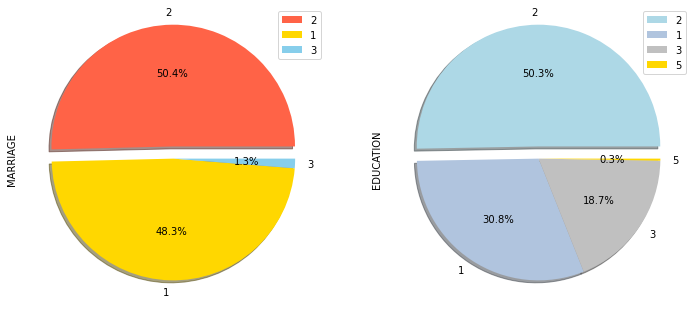

In [11]:
### X4: Marital status (1 = married; 2 = single; 3 = others) ##
### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others) ###

## To study on other categorical features like education and marital status ##

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 12))

counts_ = defaulters_data['MARRIAGE'].value_counts()
# print(counts_)
my_explode = (0.1, 0, 0)
count_to_have = counts_[counts_ >= 20]
count_to_have.plot(kind='pie', autopct='%1.1f%%', textprops={'fontsize': 10}, colors=['tomato', 'gold', 'skyblue','silver'], ax=ax1, shadow=True, explode=my_explode, legend = True)

counts_ = defaulters_data['EDUCATION'].value_counts()
# print(counts_)
count_to_have = counts_[counts_ >= 10]
my_explode = (0.1, 0, 0,0)
count_to_have.plot(kind='pie', autopct='%1.1f%%', textprops={'fontsize': 10}, colors=['lightblue','lightsteelblue','silver', 'gold'], ax=ax2, shadow=True, explode=my_explode, legend = True)
plt.show()

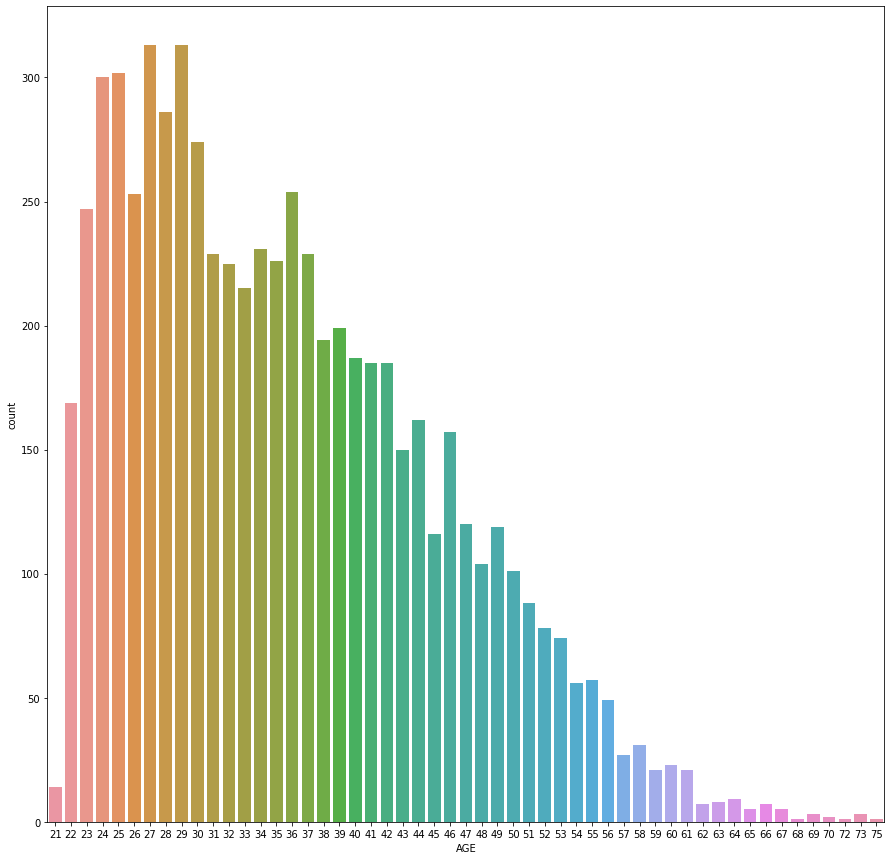

In [12]:
## To know more about age feature ##

plt.figure(figsize=[15, 15])
sns.countplot(x = 'AGE', data = defaulters_data)
plt.show()

In [13]:
## Prepare different categories of features for correlation analysis ##

num_var = ['LIMIT_BAL','PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4',
       'BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3', 'PAY_AMT4','PAY_AMT5','PAY_AMT6', 'default payment next month']

demo_cat = ['SEX', 'EDUCATION','MARRIAGE','AGE', 'default payment next month']

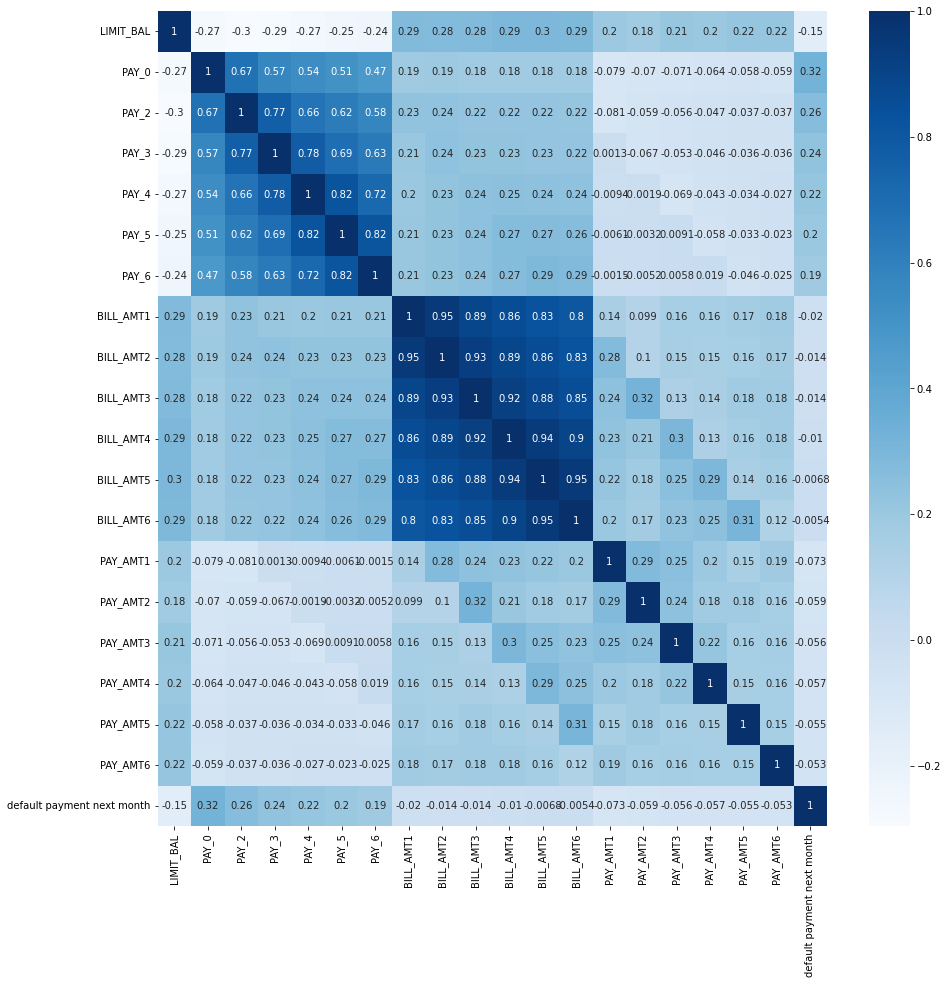

In [14]:
## All numerical features ##
plt.figure(figsize=(15,15))
cor = data[num_var].corr()
sns.heatmap(cor, annot=True, cmap="Blues")
plt.show()

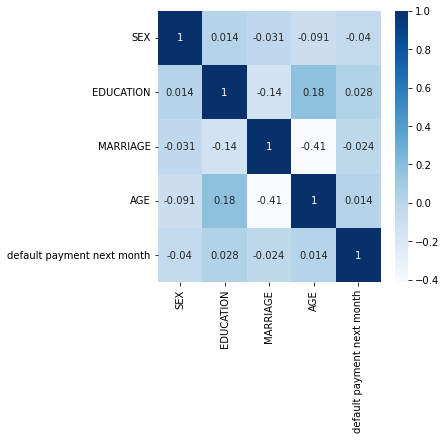

In [15]:
## All categorical features ##
plt.figure(figsize=(5,5))
cor = data[demo_cat].corr()
sns.heatmap(cor, annot=True, cmap="Blues")
plt.show()

Index(['default payment next month', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'EDUCATION', 'AGE', 'BILL_AMT6', 'BILL_AMT5'],
      dtype='object')


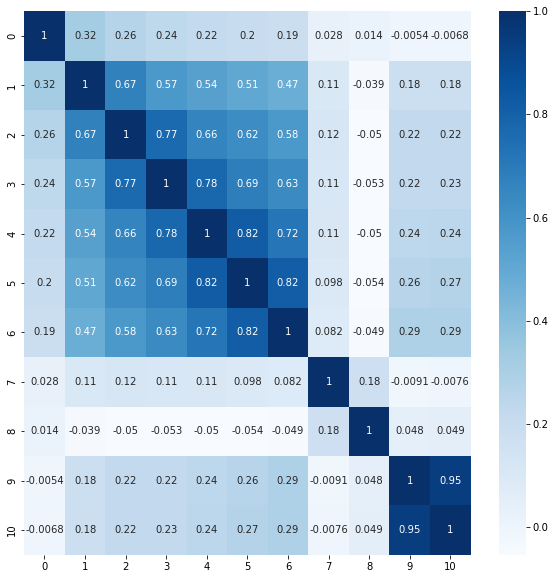

In [16]:
## Top correlated features ##
plt.figure(figsize=(10,10))
k = 11 ##Select features with target
corr_matrix = data.corr()
cols = corr_matrix.nlargest(k, 'default payment next month')['default payment next month'].index
print(cols)
cm = np.corrcoef(data[cols].values.T)
# plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

## Prediction Models

In [17]:
## Data Transformation is done using Standardscaler ##
df = data.copy()
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [18]:
r_clf = RandomForestClassifier(n_estimators=50, random_state=28)
r_clf.fit(X_train_scaled, y_train)
y_pred=r_clf.predict(X_test_scaled)

print("Non Encoded RF")
print(classification_report(y_test, y_pred))
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("ROC AUC Score:",roc_auc_score(y_test, y_pred))

lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)

print("Non encoded LR")
print(classification_report(y_test, y_pred))
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("ROC AUC Score:",roc_auc_score(y_test, y_pred))

xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': xgb_model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
y_pred = xgb_model.predict(X_test_scaled)

print("Non Encoded XGB")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Non Encoded RF
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.65      0.36      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000

Accuracy Score: 0.8165
ROC AUC Score: 0.6511823713595203
Non encoded LR
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4687
           1       0.69      0.24      0.35      1313

    accuracy                           0.81      6000
   macro avg       0.76      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

Accuracy Score: 0.8098333333333333
ROC AUC Score: 0.603328696264286
Non Encoded XGB
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.64      0.36      0.46      1313

    accurac

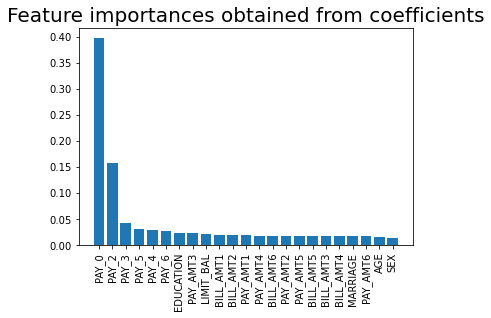

In [19]:
## Plot feature importances from XGBClassifier ##
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Prediction with encoded variables

In [20]:
## Encode categorical variables and re-run the models ##
model_cat_var = data[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
model_numerical = data[['LIMIT_BAL', 'AGE', 'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']]


encoder = OneHotEncoder(sparse=False)
model_cat = encoder.fit_transform(model_cat_var)
encoded_cols = encoder.get_feature_names_out(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
model_cat = pd.DataFrame(model_cat, columns=encoded_cols)
concated_encoded = pd.concat([model_cat, model_numerical], axis = 1)

# print(concated_encoded.head(5))

df = concated_encoded.copy()
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.2, random_state=42)

ss = StandardScaler()
X_train_scaled_encoded = ss.fit_transform(X_train_encoded)
X_test_scaled_encoded = ss.transform(X_test_encoded)

In [21]:
## Encoded block ##
enc_xgb_model = XGBClassifier()
enc_xgb_model.fit(X_train_scaled_encoded, y_train_encoded)
y_pred_encoded = enc_xgb_model.predict(X_test_scaled_encoded)

print("Encoded XGB")
print(classification_report(y_test_encoded, y_pred_encoded))
print("Accuracy Score:",accuracy_score(y_test_encoded, y_pred_encoded))
print("ROC AUC Score:", roc_auc_score(y_test_encoded, y_pred_encoded))

enc_r_clf = RandomForestClassifier(n_estimators=50, random_state=28)
enc_r_clf.fit(X_train_scaled_encoded,y_train_encoded)
y_pred_encoded =enc_r_clf.predict(X_test_scaled_encoded)

print("Encoded RF")
print(classification_report(y_test_encoded, y_pred_encoded))
print("Accuracy Score:",accuracy_score(y_test_encoded, y_pred_encoded))
print("ROC AUC Score:",roc_auc_score(y_test_encoded, y_pred_encoded))

enc_lr_model = LogisticRegression()
enc_lr_model.fit(X_train_scaled_encoded, y_train_encoded)
y_pred_encoded = enc_lr_model.predict(X_test_scaled_encoded)

print("Encoded LR")
print(classification_report(y_test_encoded, y_pred_encoded))
print("Accuracy Score:",accuracy_score(y_test_encoded, y_pred_encoded))
print("ROC AUC Score:",roc_auc_score(y_test_encoded, y_pred_encoded))

Encoded XGB
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.65      0.36      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Accuracy Score: 0.8176666666666667
ROC AUC Score: 0.6543962810717072
Encoded RF
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.66      0.36      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Accuracy Score: 0.8185
ROC AUC Score: 0.6532848957049452
Encoded LR
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.34      0.45      1313

    accuracy          

## Prediction with selected variables 

In [22]:
## Using correlated variables ##
df_X = data[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','EDUCATION','AGE','BILL_AMT6','BILL_AMT5']]
df_y = data[['default payment next month']]

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

ss = StandardScaler()
X_train_scaled_sel = ss.fit_transform(X_train_sel)
X_test_scaled_sel = ss.transform(X_test_sel)

In [23]:
lr_model_sel = LogisticRegression()
lr_model_sel.fit(X_train_scaled_sel, y_train_sel)
y_pred_sel = lr_model_sel.predict(X_test_scaled_sel)

print("Selected LR")
print(classification_report(y_test_sel, y_pred_sel))
print("Accuracy Score:",accuracy_score(y_test_sel, y_pred_sel))
print("ROC AUC Score:",roc_auc_score(y_test_sel, y_pred_sel))

sel_r_clf = RandomForestClassifier(n_estimators=50, random_state=28)
sel_r_clf.fit(X_train_scaled_sel,y_train_sel)
y_pred_sel =sel_r_clf.predict(X_test_scaled_sel)

print("Selected RF")
print(classification_report(y_test_sel, y_pred_sel))
print("Accuracy Score:",accuracy_score(y_test_sel, y_pred_sel))
print("ROC AUC Score:",roc_auc_score(y_test_sel, y_pred_sel))

sel_xgb_model = XGBClassifier()
sel_xgb_model.fit(X_train_scaled_sel, y_train_sel)
y_pred_sel = sel_xgb_model.predict(X_test_scaled_sel)

print("Selected XGB")
print(classification_report(y_test_sel, y_pred_sel))
print("Accuracy Score:",accuracy_score(y_test_sel, y_pred_sel))
print("ROC AUC Score:",roc_auc_score(y_test_sel, y_pred_sel))

Selected LR
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4687
           1       0.69      0.22      0.33      1313

    accuracy                           0.81      6000
   macro avg       0.75      0.59      0.61      6000
weighted avg       0.79      0.81      0.77      6000

Accuracy Score: 0.8073333333333333
ROC AUC Score: 0.5946011646675163
Selected RF
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4687
           1       0.58      0.35      0.43      1313

    accuracy                           0.80      6000
   macro avg       0.71      0.64      0.66      6000
weighted avg       0.78      0.80      0.78      6000

Accuracy Score: 0.8018333333333333
ROC AUC Score: 0.6376827643539656
Selected XGB
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.66      0.36      0.47      1313

    acc

## Hyperparameter Optimization - Grid Search and Random search

In [24]:
### Tuning Hyperparameters for LR ###
lr_model_op = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
print(lr_model_op.get_params())
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
random_search = RandomizedSearchCV(lr_model_op, distributions, random_state=0)
result_lr_op = random_search.fit(X_train_scaled_encoded, y_train_encoded)

print('Best Hyperparameters: %s' % result_lr_op.best_params_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'saga', 'tol': 0.01, 'verbose': 0, 'warm_start': False}
Best Hyperparameters: {'C': 2.195254015709299, 'penalty': 'l1'}


In [25]:
### Tuning Hyperparameters for RF ###
param_dist = {'n_estimators': [100,200,300],
               "max_features": [1,2,3,4,5,6,7,8,9,10],
               'max_depth': [1,2,3,4,5],
               "criterion": ["gini", "entropy"]}

rf_model_op = RandomForestClassifier()
rf_model_op = RandomizedSearchCV(rf_model_op, cv = 5, param_distributions = param_dist, random_state=0, n_jobs = -1)
rf_model_op.fit(X_train_scaled_encoded, y_train_encoded)

print("Best Parameters: %s" % (rf_model_op.best_params_))

Best Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 5, 'criterion': 'gini'}


In [36]:
## Tuning Hyperparamters for XGBClassifier ##
params = {
        'gamma': [0.5, 1, 5],   # regularization param
        'subsample': [0.5, 1.0], # % of rows taken for every tree
        'colsample_bytree': [0.5, 1.0], # no of cols used by every tree
        'max_depth': [3, 4, 5] # every tree's depth
        }

xgb_model_opt = XGBClassifier(learning_rate=0.01, n_estimators=200, objective='binary:logistic')
grid_search = GridSearchCV(xgb_model_opt, params, refit = True, verbose = 2)
grid_search.fit(X_train_scaled_encoded, y_train_encoded)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=0.5; total time=   1.6s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=0.5; total time=   1.6s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=0.5; total time=   1.6s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.5, gamma=0.5, max_depth=3, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.5, gamma=0.5, max_de

[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, subsample=0.5; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, subsample=0.5; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=4, subsample=0.5; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=4, subsample=0.5; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=4, subsample=0.5; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=4, subsample=0.5; total time=   4.0s
[CV] END colsample_by

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_bin=None,
                                     max_cat_to_...=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.5, 1.0], 'gamma': [0.5, 1, 5],
                         'max_depth': [3, 4, 5], 'subsample': [0.5, 1.0]},
             verbose=2)

In [37]:
y_predict_XGB = grid_search.predict(X_test_encoded)

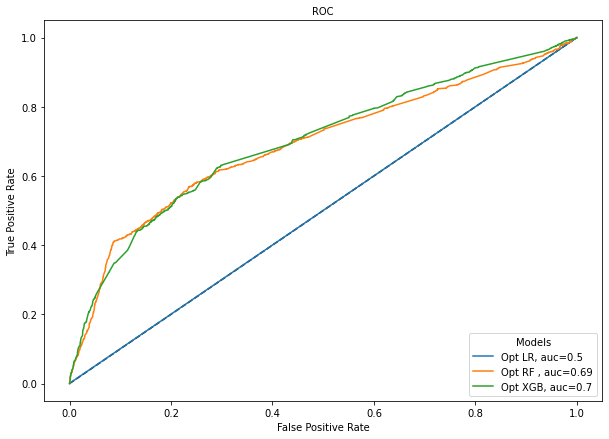

In [38]:
## ROC curves for different models so far ##
y_pred_opt_LR = random_search.predict_proba(X_test_encoded)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test_encoded,  y_pred_opt_LR)
auc1 = metrics.roc_auc_score(y_test_encoded, y_pred_opt_LR)

y_pred_opt_RF = rf_model_op.predict_proba(X_test_encoded)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test_encoded,  y_pred_opt_RF)
auc2 = metrics.roc_auc_score(y_test_encoded, y_pred_opt_RF)

y_pred_opt_XGB = grid_search.predict_proba(X_test_encoded)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test_encoded,  y_pred_opt_XGB)
auc3 = metrics.roc_auc_score(y_test_encoded, y_pred_opt_XGB)

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Opt LR, auc="+str(round(auc1,2)))
plt.plot(fpr2,tpr2,label="Opt RF , auc="+str(round(auc2,2)))
plt.plot(fpr3,tpr3,label="Opt XGB, auc="+str(round(auc3,2)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=10)
plt.show()